In [1]:
import os
import gc
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SyntaxSquad/
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1y5j_w0jTp2u2rRUY8iyzaI8Vpo5gPy7d/SyntaxSquad
datasets  GISLR_best_solution.ipynb  pose2gloss  preprocessing	SyntaxSquad.ipynb


In [5]:
from collections import Counter
landmarks_dict = np.load('./datasets/WLASL_landmarks.npz', allow_pickle=True)

with open('./datasets/WLASL_parsed_metadata.json', 'r') as json_file:
    parsed_metadata = json.load(json_file)
    glosses_counts = dict(Counter(item['gloss'] for item in parsed_metadata).most_common())
print(glosses_counts)

{'book': 40, 'drink': 35, 'computer': 30, 'before': 26, 'chair': 26, 'go': 26, 'clothes': 25, 'who': 25, 'candy': 24, 'cousin': 23, 'deaf': 23, 'fine': 22, 'help': 22, 'no': 22, 'thin': 22, 'walk': 22, 'year': 22, 'yes': 22, 'all': 21, 'black': 21, 'cool': 21, 'finish': 21, 'hot': 21, 'like': 21, 'many': 21, 'mother': 21, 'now': 21, 'orange': 21, 'table': 21, 'thanksgiving': 21, 'what': 21, 'woman': 21, 'bed': 20, 'blue': 20, 'bowling': 20, 'can': 20, 'dog': 20, 'family': 20, 'fish': 20, 'graduate': 20, 'hat': 20, 'hearing': 20, 'kiss': 20, 'language': 20, 'later': 20, 'man': 20, 'shirt': 20, 'study': 20, 'tall': 20, 'white': 20, 'wrong': 20, 'accident': 19, 'apple': 19, 'bird': 19, 'change': 19, 'color': 19, 'corn': 19, 'cow': 19, 'dance': 19, 'dark': 19, 'doctor': 19, 'eat': 19, 'enjoy': 19, 'forget': 19, 'give': 19, 'last': 19, 'meet': 19, 'pink': 19, 'pizza': 19, 'play': 19, 'school': 19, 'secretary': 19, 'short': 19, 'time': 19, 'want': 19, 'work': 19, 'africa': 18, 'basketball': 

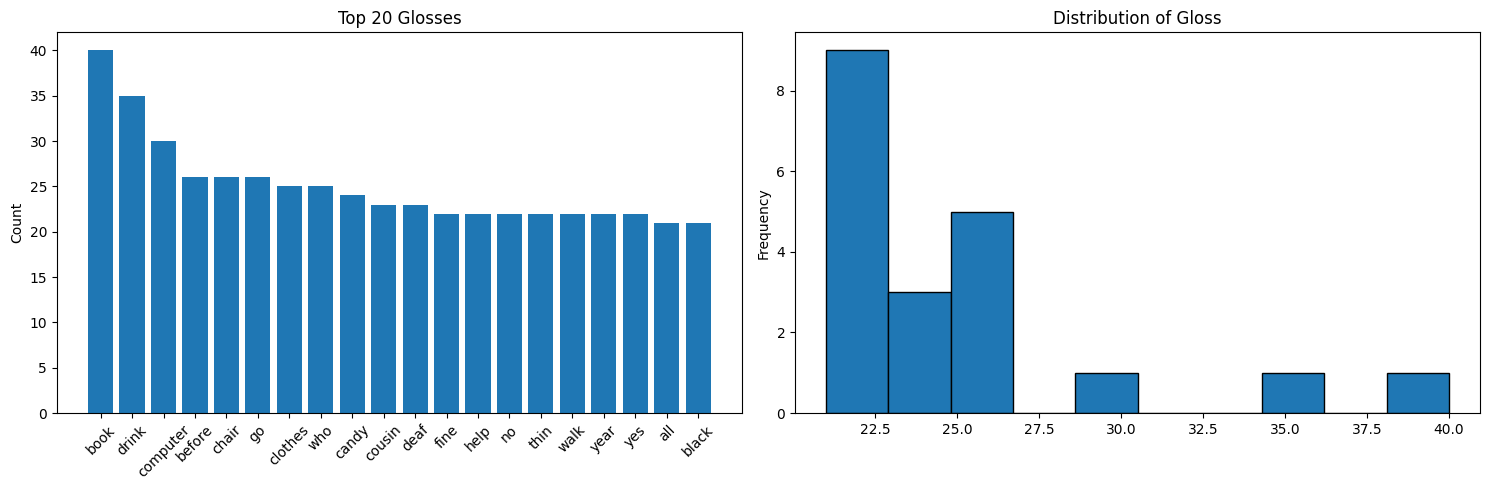

In [6]:
top_n = 20
glosses = list(glosses_counts.keys())[:top_n]
counts = list(glosses_counts.values())[:top_n]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(glosses, counts)
plt.ylabel('Count')
plt.title('Top 20 Glosses')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(counts, edgecolor='black')
plt.ylabel('Frequency')
plt.title('Distribution of Gloss')
plt.tight_layout()
plt.show()

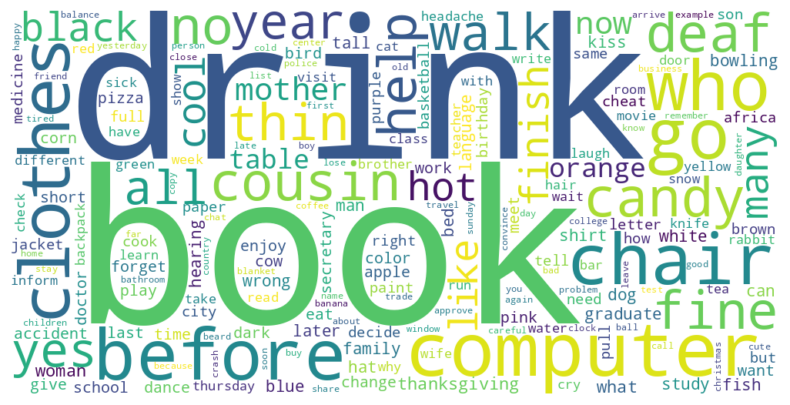

In [7]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(glosses_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data Splitting

In [8]:
# For the new *.npz with metadata information
# def load_subset(split, chosen_landmarks=None, chosen_labels=None, max_labels=None, max_samples=None):
#     if chosen_landmarks is None: landmarks = list(range(landmarks_dict[0].shape[1]))
#     X, y = [], []
#     for idx, item in tqdm(landmarks_dict.items()):
#         if item['split'] != split or \
#            (max_samples and idx >= max_samples) or \
#            (chosen_labels and item['gloss'] not in chosen_labels) or \
#            (max_labels and item['gloss'] not in list(label_counts.keys())[:max_labels]):
#             continue
#         X.append(item['landmarks'][:, chosen_landmarks, :])
#         y.append(item['gloss'])
#     return X, y

In [9]:
def load_subset(split, chosen_landmarks=None, chosen_labels=None, max_labels=None, max_samples=None):
    chosen_landmarks = chosen_landmarks or list(range(landmarks_dict['0'].shape[1]))
    if max_labels: chosen_labels = set(list(glosses_counts.keys())[:max_labels])
    elif chosen_labels: chosen_labels = set(chosen_labels)
    X, y = [], []

    for k, landmarks in tqdm(landmarks_dict.items(), desc=f'Splitting {split} subset'):
        meta = parsed_metadata[int(k)]
        if meta['split'] != split: continue
        if chosen_labels is None or meta['gloss'] in chosen_labels:
            X.append(landmarks[:, chosen_landmarks, :])
            y.append(meta['gloss'])
    return (X[:max_samples], y[:max_samples]) if max_samples else (X, y)

In [10]:
# X_train, y_train = load_subset('train', chosen_labels=similar_words_list)
# X_val, y_val = load_subset('val', chosen_labels=similar_words_list)
# X_test, y_test = load_subset('test', chosen_labels=similar_words_list)
X_train, y_train = load_subset('train', max_labels=100)
X_val, y_val = load_subset('val', max_labels=100)
X_test, y_test = load_subset('test', max_labels=100)

print('First video has', len(X_train[0]), 'frames with', len(X_train[0][0]), 'landmarks')
del landmarks_dict, parsed_metadata
gc.collect()

Splitting train subset:   0%|          | 0/21083 [00:00<?, ?it/s]

Splitting val subset:   0%|          | 0/21083 [00:00<?, ?it/s]

Splitting test subset:   0%|          | 0/21083 [00:00<?, ?it/s]

First video has 72 frames with 180 landmarks


10076

### Statistics Summary

In [11]:
def subset_statistics(X, y, subset_name='Subset'):
    num_videos, num_classes = len(X), len(np.unique(y))
    avg_frames_per_video, avg_landmarks_per_frame = 0, 0
    if num_videos > 0:
        avg_frames_per_video = np.mean([len(video) for video in X])
        avg_landmarks_per_frame = np.mean([len(video[0]) for video in X if len(video) > 0])

    return pd.DataFrame({
        'Subset': [subset_name],
        'Number of Videos': [num_videos],
        'Number of Classes': [num_classes],
        'Average Frames/Video': [avg_frames_per_video],
        'Number of Landmarks/Frame': [avg_landmarks_per_frame]
    })

In [12]:
# Compute high-level statistics
train_stats = subset_statistics(X_train, y_train, 'Train')
val_stats = subset_statistics(X_val, y_val, 'Validation')
test_stats = subset_statistics(X_test, y_test, 'Test')
subset_summary = pd.concat([train_stats, val_stats, test_stats], ignore_index=True)

# Create detailed statistics DataFrame
train_details = pd.DataFrame({
    'Subset': ['Train'] * len(X_train),
    'Gloss': y_train,
    'Video Length': [len(video) for video in X_train],
    'Frame Landmarks': [len(video[0]) for video in X_train]
})

val_details = pd.DataFrame({
    'Subset': ['Validation'] * len(X_val),
    'Gloss': y_val,
    'Video Length': [len(video) for video in X_val],
    'Frame Landmarks': [len(video[0]) for video in X_val]
})

test_details = pd.DataFrame({
    'Subset': ['Test'] * len(X_test),
    'Gloss': y_test,
    'Video Length': [len(video) for video in X_test],
    'Frame Landmarks': [len(video[0]) for video in X_test]
})

In [13]:
# Combine descriptive statistics
combined_details = pd.concat([train_details, val_details, test_details], ignore_index=True)
detailed_stats = combined_details.groupby('Subset').agg({
    'Video Length': ['mean', 'std', 'min', 'max'],
    # 'Frame Landmarks': ['mean', 'std', 'min', 'max']
}).reset_index()

# Merge high-level and detailed statistics
detailed_stats.columns = ['Subset'] + [f"{col[0]} ({col[1]})" for col in detailed_stats.columns[1:]]
final_stats = pd.merge(subset_summary, detailed_stats, on='Subset')
final_stats

,Subset,Number of Videos,Number of Classes,Average Frames/Video,Number of Landmarks/Frame,Video Length (mean),Video Length (std),Video Length (min),Video Length (max)
0,Train,1442,100,65.371012,180.0,65.371012,24.098723,13,195
1,Validation,338,100,66.760355,180.0,66.760355,25.395482,12,195
2,Test,258,100,62.461240,180.0,62.461240,24.186702,18,148


### Visualizations

In [14]:
import plotly.express as px
fig = px.histogram(combined_details, x='Video Length', color='Subset', barmode='overlay', nbins=20)
fig.update_layout(
    title='Distribution of Video Lengths for Each Subset',
    xaxis_title='Video Length',
    yaxis_title='Frequency',
    legend_title='Subset'
)
fig.show()

In [15]:
fig = px.box(combined_details, x='Subset', y='Video Length', color='Subset')
fig.update_layout(
    title='Video Length Distribution by Set',
    xaxis_title='Subset',
    yaxis_title='Video Length (Frames)'
)

# Training Augmentation

In [16]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

In [17]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = ((
        data[non_zero[:, 0], non_zero[:, 1], :2] - center
    ) * factor + center)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))
    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

### Apply Augmentation

In [18]:
def apply_augmentation(data):
    aug_funcs = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_funcs)
    count = 0
    for func in aug_funcs:
        if np.random.rand() < 0.5:
            data = func(data)
            count += 1
    if count == 0: data = apply_augmentation(data)
    return data

In [19]:
def augment(X, y, num=None):
    X_aug, y_aug = X.copy(), y.copy()
    for i in tqdm(range(len(y))):
        for _ in range(num or np.random.choice([1, 2, 3])):
            X_aug.append(apply_augmentation(X[i].copy()))
            y_aug.append(y[i])
    return X_aug, y_aug

In [20]:
X_train, y_train = augment(X_train, y_train, num=1)
print('The Training set has', len(X_train), 'videos')
print('First video has', len(X_train[0]), 'frames')
print('Each frame has', len(X_train[0][0]), 'landmarks')
print('Each landmark has', len(X_train[0][0][0]), 'coordinates')
gc.collect()

  0%|          | 0/1442 [00:00<?, ?it/s]

The Training set has 2884 videos
First video has 72 frames
Each frame has 180 landmarks
Each landmark has 3 coordinates


673

### Test Augmentation

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# example_frame_landmarks = np.expand_dims(example_frame_landmarks, axis=0)
# for landmark in example_frame_landmarks[0]:
#     x = int(landmark[0] * img.shape[1])
#     y = int(landmark[1] * img.shape[0])
#     cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

# axs[0].set_title('Original Image')
# axs[0].imshow(img[:, :, ::-1])
# axs[0].axis('off')

# augmented_landmarks = apply_augmentation(example_frame_landmarks.copy())
# img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
# for landmark in augmented_landmarks[0]:
#     x = int(landmark[0] * img.shape[1])
#     y = int(landmark[1] * img.shape[0])
#     cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

# axs[1].set_title('Augmented Image')
# axs[1].imshow(img[:, :, ::-1])
# axs[1].axis('off')
# plt.tight_layout()
# plt.show()